## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*


In [2]:
import numpy as np
import scipy.stats as stats

# Define the log-likelihood function
def log_likelihood(x, mu, sigma2, nu):
    n = len(x)
    return np.sum(stats.t.logpdf(x, df=nu, loc=mu, scale=np.sqrt(sigma2)))  # Log Student-t likelihood

# Define log-priors
def log_prior_mu(mu, mu0=0, tau0=1):
    return stats.norm.logpdf(mu, loc=mu0, scale=np.sqrt(tau0))

def log_prior_sigma2(sigma2, sigma0=1):
    return stats.halfnorm.logpdf(np.sqrt(sigma2), scale=np.sqrt(sigma0))

def log_prior_nu(nu):
    return np.log(1 / 100) if 1 <= nu <= 100 else -np.inf  # Log of discrete uniform prior

# Log posterior
def log_posterior(x, mu, sigma2, nu):
    return log_likelihood(x, mu, sigma2, nu) + log_prior_mu(mu) + log_prior_sigma2(sigma2) + log_prior_nu(nu)

# Metropolis-Hastings step on a log-scale
def metropolis_step_log(current, proposal_sd, log_posterior, *args):
    proposal = np.random.normal(current, proposal_sd)  # Symmetric normal proposal
    log_acceptance_ratio = log_posterior(proposal, *args) - log_posterior(current, *args)
    if np.log(np.random.rand()) < log_acceptance_ratio:
        return proposal  # Accept
    else:
        return current  # Reject

# Gibbs Sampler with Metropolis-Hastings
def metropolis_within_gibbs_log(x, n_iter=5000, proposal_sd=0.1):
    # Initial values
    mu = np.mean(x)
    sigma2 = np.var(x)
    nu = np.random.randint(1, 101)
    
    samples = np.zeros((n_iter, 3))  # Store (mu, sigma2, nu)

    for i in range(n_iter):
        # Sample mu | rest
        mu = metropolis_step_log(mu, proposal_sd, lambda m: log_posterior(x, m, sigma2, nu))

        # Sample sigma2 | rest
        sigma2 = metropolis_step_log(sigma2, proposal_sd, lambda s: log_posterior(x, mu, s, nu))

        # Sample nu | rest (discrete uniform, use log probability ratio)
        nu_proposal = np.random.randint(1, 101)
        log_accept_ratio = log_posterior(x, mu, sigma2, nu_proposal) - log_posterior(x, mu, sigma2, nu)
        if np.log(np.random.rand()) < log_accept_ratio:
            nu = nu_proposal

        samples[i] = [mu, sigma2, nu]

    return samples

# Generate synthetic data for testing
np.random.seed(42)
n = 100
true_mu, true_sigma2, true_nu = 5, 2, 10
x_data = stats.t.rvs(df=true_nu, loc=true_mu, scale=np.sqrt(true_sigma2), size=n)

# Run the improved sampler
samples_log = metropolis_within_gibbs_log(x_data)

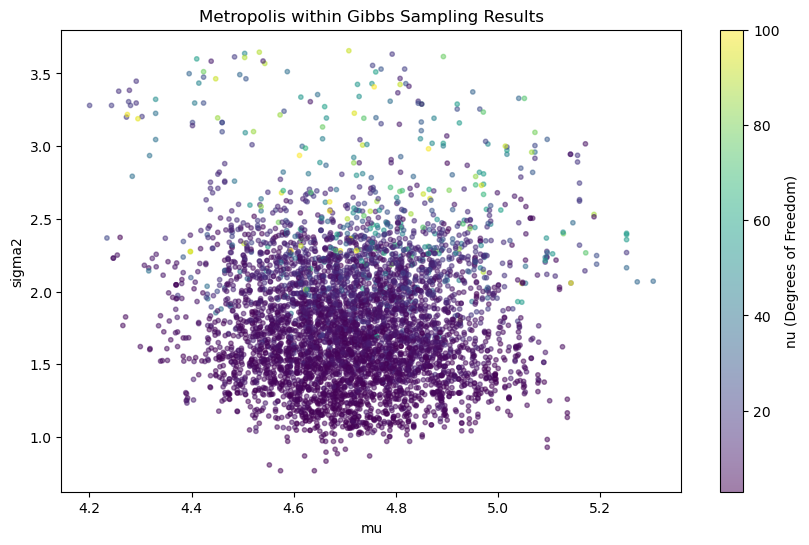

In [4]:
import matplotlib.pyplot as plt

# Scatter plot of sampled values
plt.figure(figsize=(10, 6))
plt.scatter(df_samples_log["mu"], df_samples_log["sigma2"], alpha=0.5, s=10, c=df_samples_log["nu"], cmap="viridis")
plt.colorbar(label="nu (Degrees of Freedom)")
plt.xlabel("mu")
plt.ylabel("sigma2")
plt.title("Metropolis within Gibbs Sampling Results")
plt.show()

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*


In [6]:
import arviz as az
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data (if needed)
np.random.seed(42)
n = 100
true_mu, true_sigma2, true_nu = 5, 2, 10
x_data = np.random.standard_t(df=true_nu, size=n) * np.sqrt(true_sigma2) + true_mu

# Define and run the corrected PyMC model
def run_pymc_model_correct(x_data, sample_size=500):
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=1)
        sigma2 = pm.HalfNormal("sigma2", sigma=1)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Correctly defined discrete prior

        likelihood = pm.StudentT("obs", nu=nu, mu=mu, sigma=pm.math.sqrt(sigma2), observed=x_data)

        step1 = pm.NUTS([mu, sigma2])  # NUTS for continuous parameters
        step2 = pm.Metropolis([nu])  # Metropolis for discrete nu

        trace = pm.sample(sample_size, step=[step1, step2], return_inferencedata=True, cores=1, tune=250)
    
    return trace

# Run the model
trace_correct = run_pymc_model_correct(x_data, sample_size=500)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Sampling 2 chains for 250 tune and 500 draw iterations (500 + 1_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


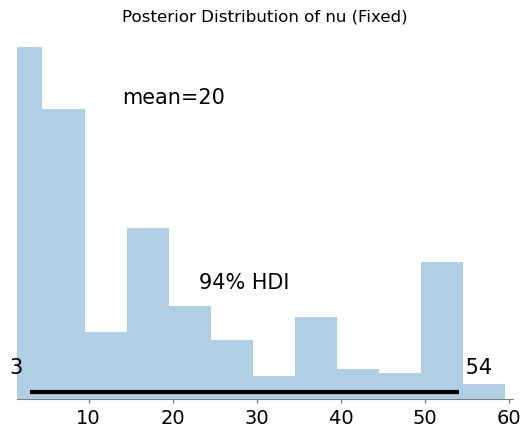

In [8]:
# Plot posterior distributions of nu for different sample sizes
az.plot_posterior(trace_correct, var_names=["nu"])
plt.title("Posterior Distribution of nu (Fixed)")
plt.show()

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



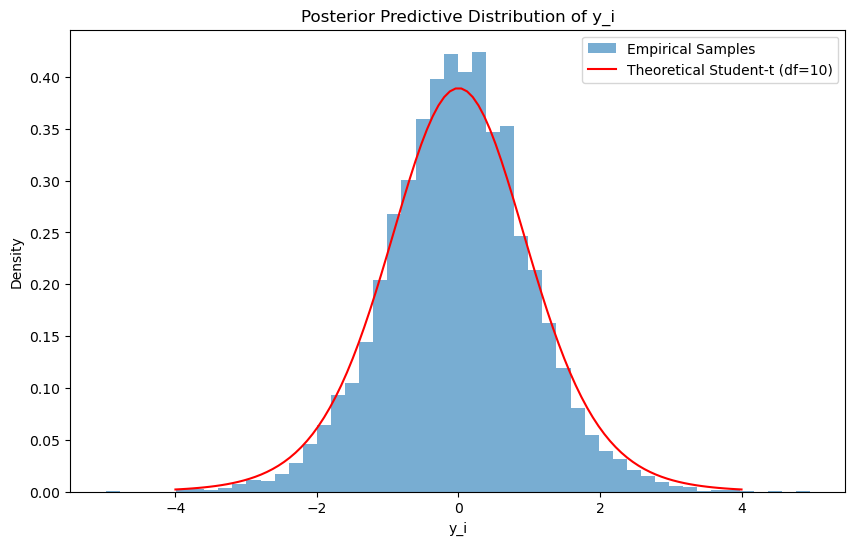

In [10]:
# Step 1: Define the number of samples
n_samples = 10000
nu = 10  # Degrees of freedom

# Step 2: Sample tau_i from Gamma(nu/2, nu/2)
tau_samples = stats.gamma.rvs(a=nu/2, scale=2/nu, size=n_samples)  # scale = 1/rate

# Step 3: Sample y_i from N(0, tau_i)
y_samples = stats.norm.rvs(loc=0, scale=np.sqrt(tau_samples), size=n_samples)

# Step 4: Compare empirical and theoretical distributions
x_vals = np.linspace(-4, 4, 100)
student_t_pdf = stats.t.pdf(x_vals, df=nu)

# Histogram vs Theoretical Student-t
plt.figure(figsize=(10, 6))
plt.hist(y_samples, bins=50, density=True, alpha=0.6, label="Empirical Samples")
plt.plot(x_vals, student_t_pdf, 'r-', label=f"Theoretical Student-t (df={nu})")
plt.xlabel("y_i")
plt.ylabel("Density")
plt.title("Posterior Predictive Distribution of y_i")
plt.legend()
plt.show()